In [1]:
import torch as th 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Toy Data

Simple math expression with variables and their results
```txt
EXPR -> $k - ( k / a - e );k=8.41,e=9.85,a=5.48! 
RES -> [16.73]
```

In [2]:
from simple_expressions import SimpleExpression, expr_vocabulary, PADDING_TOKEN_ID, UNKNOWN_CHAR_ID, START_OF_ANSWER, encode_expression, decode_expression

class ExpSentence(SimpleExpression):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.vocab = expr_vocabulary
        
    def sample(self, batch_size: int):
        expression, target = super().sample(batch_size)
        full_sentence = []
        answer_break_points = []
        for i in range(batch_size):
            full_sentence.append(expression[i]  + target[i])
            answer_break_points.append(len(expression[i]))
        return full_sentence, answer_break_points

    def create_training_batch(self, context_window: int, batch_size: int):
        sentences, break_points = self.sample(batch_size) 

        encoded_sentences = []
        for i in range(len(sentences)):
            # clipping longer strings
            if break_points[i] > context_window:
                clip_size = break_points[i] - context_window
                sentences[i] = sentences[i][clip_size:]
                break_points[i] = context_window
                assert sentences[i][context_window] == START_OF_ANSWER, f'"{sentences[i]}"'
                
            left_pad = context_window - break_points[i]
            sent_enc = []
            for _ in range(left_pad):
                sent_enc.append(PADDING_TOKEN_ID)

            for x in sentences[i]:
                sent_enc.append(self.vocab.get(x,UNKNOWN_CHAR_ID))
            encoded_sentences.append(sent_enc)
        # shift each setences by one after '[', [max_expression_size+1:] is the context window 
        # and '[' will be the first attention query
        batches = []        
        for encoded_sentence in encoded_sentences:
            for i in range(len(encoded_sentence) - context_window-1):
                batches.append(encoded_sentence[i:i+ context_window+2])

        # safety check
        # starts with  '>' '['
        assert batches[0][-2] == self.vocab[START_OF_ANSWER]
        for b in batches:
            assert b[-1] != self.vocab[START_OF_ANSWER], f"{b}"
            
        return th.tensor(batches, dtype=th.long)
                
                
sampler = ExpSentence(3, (1, 3), (-10, 10), 2, 0.5)
batch = sampler.create_training_batch(64, 2)
batch.shape # [Batch, cntxt+1 + 1]

torch.Size([11, 66])

# Additive Attention

Attending to previous tokens using the -1 as query

using the additive attention
$$
\alpha(q,k) = w_v^T tanh(W_q q + W_k k) \in R
$$
and attention pooling
$$
Attention(q,\mathcal{D}) = \sum_{i=1}^m \alpha (q, k_i)v_i,
$$
but v = k.

In [3]:
class AttentionPool(th.nn.Module):
    def __init__(self,input_dim: int, hidden_dim: int):
        super().__init__()

        self.query = th.nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.key = th.nn.Linear(in_features=input_dim, out_features=hidden_dim)

        self.weight = th.nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, q: th.Tensor, v: th.Tensor, pad_mask: th.Tensor,):
        """ If key values aren't provided, will use the v as both key and value """
        # q: [B, n]
        # v: [B, m, n] where D: [m, n] 
        query_out = self.query(q).unsqueeze(1) # [B,1,k] when single query 
        keys_out = self.key(v) # [B, m, k]
        
        # additive attention by broad casting
        additive_attention = th.tanh(query_out + keys_out)

        e = self.weight(additive_attention).squeeze(-1) # [B, m]
        # for softmax calculation to ignore the padded fields, we need to set them as -inf
        # https://juditacs.github.io/2018/12/27/masked-attention.html
        e = e.masked_fill(pad_mask,  float('-inf'))

        alpha = th.softmax(e, dim=-1).unsqueeze(-1) # [B, m, 1] 
        attention_pool = (alpha*v).sum(dim=1) # [B, n]
        return attention_pool


with th.no_grad():
    batch = 10
    contxt_window = 32
    embedding_size = 5
    attn_pool = AttentionPool(input_dim=embedding_size, hidden_dim=3)
    # setting right half as valid tokens and left as paddings
    pad_mask = th.zeros(batch, contxt_window)
    pad_mask[:, contxt_window//2:] = 1 
    pad_mask = (pad_mask==0)
    
    que = th.randn(batch, embedding_size)
    val = th.randn(batch, contxt_window, embedding_size)
    out = attn_pool(que, val, pad_mask)
    assert out.shape == (batch, embedding_size)

# Self-Attention

Using the input and weights \(Q, K, V\) to get the query, key & value vectors

Using additive attention will require too much memory due to the (Wq + Wk) operation which requires broadcasting the matrix to (B, seq, seq, n), so using simple dot production attention (we already have parameters to produce q,k,v using embeddings).

In [4]:
class SelfAttention(th.nn.Module):
    def __init__(self,input_dim: int, output_dim: int):
        super().__init__()
        
        self.query = th.nn.Linear(in_features=input_dim, out_features=output_dim)
        self.key = th.nn.Linear(in_features=input_dim, out_features=output_dim)
        self.value = th.nn.Linear(in_features=input_dim, out_features=output_dim)

    def forward(self, x: th.Tensor, pad_mask: th.Tensor):
        # x: [B, m, n]

        # All [B, m, k] and k is the out_dim
        query = self.query(x) 
        keys = self.key(x)
        vals = self.value(x)

        # [B. m, m]
        e = query @ keys.mT 
        # each row contains q_i^T k_1, ... q_i^T k_m
        # masking the entier row will lead to all nans
        # so first lets mask the padded columns with -inf [-inf, -inf, ..., q_i^T,k_m]
        # making pad_mask to [B, 1, seq] to apply mask on each row
        e = e.masked_fill(pad_mask.unsqueeze(1),  float('-inf'))
        
        alpha = th.softmax(e, dim=-1) # [B, m, m]
        # each row has scores for [(qi, k1), ... ,(qi, km)]
        # each row in vals, v_i is the value vector
        # \sum_i^M (q1, ki) * v_i1, so the row i contains 
        # attn for query_i with all keys and first components of all val vectors
        # each row is sum of the weighted values vectors
        # scores (1, m) \cdot values (m, k) 
        attention_pool = alpha @ vals # [B, m, k]

        # now we need to take care of the padding entries
        attention_pool = attention_pool * (~pad_mask[...,None])
        return attention_pool


with th.no_grad():
    batch = 10
    contxt_window = 32
    embedding_size = 5
    out_dim = 3
    sattn = SelfAttention(input_dim=embedding_size, output_dim=out_dim)
    # setting right half as valid tokens and left as paddings
    pad_mask = th.zeros(batch, contxt_window)
    pad_mask[:, contxt_window//2:] = 1 
    pad_mask = (pad_mask==0)
    
    x = th.randn(batch, contxt_window, embedding_size)
    out = sattn(x,pad_mask)
    assert out.shape == (batch, contxt_window, out_dim)
    # left half full of zeros, right half full of values
    assert out[:,:16,:].sum() == 0
    assert abs(out[:,16:,:].sum()) >= 0

# Multihead attention

h: no. heads 
d: input dimension 

each Q,K,V $\in  R^{n \times d/h}$, outputs get concatenated and x added back for residual connections, finally layernorm -> feedfroward -> non linearity (using relu)

In [5]:
class MultiHeadAttentionBlock(th.nn.Module):
    def __init__(self, in_dim: int, out_dim: int, heads: int):
        assert in_dim % heads == 0, f"Uneven outdim and heads {in_dim} % {heads} != 0"
        super().__init__()

        self.num_heads = heads
        self.head_dim = in_dim // heads
        self._sf_scalar = self.head_dim ** 0.5
        # same matrix produce q,k,v
        self.qkv = th.nn.ModuleList([th.nn.Linear(in_features=in_dim, out_features=self.head_dim*3) for _ in range(heads)])

        self.lnorm = th.nn.LayerNorm(in_dim)
        self.feed_forward = th.nn.Linear(in_features=in_dim, out_features=out_dim)
    
    def _dot_product_self_attention(self, head: int, x: th.Tensor, pad_mask: th.Tensor):
        B, T, _ = x.shape
        qkv = self.qkv[head](x) 
        
        query, keys, vals = qkv.chunk(3, dim=-1)
        
        # [B. m, m]
        e = query @ keys.mT 
        e = e.masked_fill(pad_mask.unsqueeze(1),  float('-inf'))
        # using scalled dot product attention
        alpha = th.softmax(e/ self._sf_scalar, dim=-1) # [B, m, m]
        attention_pool = alpha @ vals # [B, m, d/h]
        attention_pool = attention_pool * (~pad_mask[...,None])
        return attention_pool

    def forward(self, x: th.Tensor, pad_mask: th.Tensor):
        # x: [B, m, d]
        # attention: [B, m, d] where d is the concatenated d/h attention pools
        attention = th.concat([self._dot_product_self_attention(head=i, x=x, pad_mask=pad_mask) for i in range(self.num_heads)],dim=-1)
        # for padding tokens the the entries in x will have 0 vectors
        resid_norm = self.lnorm(attention + x)
        logits = self.feed_forward(resid_norm) * (~pad_mask[...,None])

        return th.relu(logits)
with th.no_grad():
    batch = 10
    contxt_window = 32
    embedding_size = 8
    out_dim = 3
    mattn = MultiHeadAttentionBlock(in_dim=embedding_size, out_dim=out_dim,heads=2)
    # setting right half as valid tokens and left as paddings
    pad_mask = th.zeros(batch, contxt_window)
    pad_mask[:, contxt_window//2:] = 1 
    pad_mask = (pad_mask==0)
    
    x = th.randn(batch, contxt_window, embedding_size)
    # make the left side 0 embedding vectors
    x[:, :contxt_window//2, :] = 0 
    
    out = mattn(x,pad_mask)
    assert out.shape == (batch, contxt_window, out_dim)
        # left half full of zeros, right half full of values
    assert out[:,:16,:].sum() == 0
    assert abs(out[:,16:,:].sum()) >= 0

In [6]:
class ModelWithAttention(th.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, padding_idx: int, ctxt_size: int, heads:int):
        super().__init__()
        self._padding_id = padding_idx
        # # initialize embeddings as on hot encoded vector + small noise
        # noisy_onehot = th.eye(vocab_size) + (th.randn(vocab_size, vocab_size) - 0.5) * 0.033
        self.embeddings = th.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,padding_idx=padding_idx) #.from_pretrained(noisy_onehot, padding_idx=padding_idx)
        self.pos_embd = th.nn.Embedding(num_embeddings=ctxt_size+1, embedding_dim=embedding_dim, padding_idx=0)
        
        self.attn1 = MultiHeadAttentionBlock(embedding_dim, hidden_dim, heads)
        self.attn2 = MultiHeadAttentionBlock(hidden_dim, hidden_dim, heads)
        
        self.fc = th.nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x: th.Tensor):
        # x: [B, seq]
        x_embd = self.embeddings(x) # {B, seq, n]
        pad_mask = (x == self._padding_id)
        # [0,0,0,0,1,2,3,4..]
        token_positions = (~pad_mask).cumsum(dim=1)
        pos_embd = self.pos_embd(token_positions)
        
        x_embd += pos_embd
        
        attn1 = self.attn1(x_embd, pad_mask) # [B, seq, n]
        attn_out = self.attn2(attn1, pad_mask).sum(dim=1) # [B, n]
        return self.fc(attn_out)
        
with th.no_grad():
    model = ModelWithAttention(vocab_size=10, embedding_dim=12,hidden_dim=4, padding_idx=0,ctxt_size=32, heads=4)
    x = th.randint(0, 10, (8, 32))
    logits = model(x)
    assert logits.shape == (8, 10)

In [7]:
n_vars = 3
expr_range = (2, 5)
number_range = (-10, 10)
float_round = 2
sampler = ExpSentence(n_vars, expr_range, number_range, float_round, 0.5)

In [8]:
embedding_dim = 64
hidden_dim = 128
context_window = 512 # maximum tokens that we can fit in the context
heads = 4


calc = ModelWithAttention(vocab_size=len(sampler.vocab), embedding_dim=embedding_dim,hidden_dim=hidden_dim, padding_idx=PADDING_TOKEN_ID,ctxt_size=context_window, heads=heads)

# Total parameters
total_params = sum(p.numel() for p in calc.parameters())

# Trainable parameters only
trainable_params = sum(p.numel() for p in calc.parameters() if p.requires_grad)

print(f"Total: {total_params:,}")
print(f"Trainable: {trainable_params:,}")

param_size = 0
for param in calc.parameters():
    param_size += param.nelement() * param.element_size()
    
buffer_size = 0
for buffer in calc.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print(f"Model size: {size_all_mb:.3f} MB")

Total: 130,486
Trainable: 130,486
Model size: 0.498 MB


In [9]:
eta = 0.001

epochs = 10
batch_size = 128
batches_per_epoch = 32

criterion = th.nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_ID)
optimizer = th.optim.Adam(calc.parameters(), lr=eta)

losses = []
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    batch_bar = tqdm(range(batches_per_epoch), desc=f"Epoch #{epoch+1}", leave=False)
    for i in batch_bar:
    
        tgt = sampler.create_training_batch(batch_size, context_window)

        # past sequence, next output
        tgt_input = tgt[:, :-1]  
        tgt_output = tgt[:, -1]

        optimizer.zero_grad()
        logits = calc(tgt_input)
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_output
        )

        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)
        batch_bar.set_postfix(loss=f"{loss_val:.4f}")


Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #10:   0%|          | 0/32 [00:00<?, ?it/s]

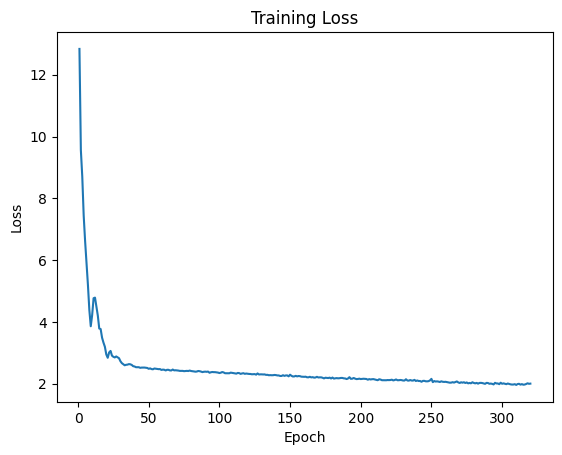

In [10]:
updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [11]:
def sample(
    calc,
    expr: str,
    max_len: int = 10,
    greedy: bool = True,
):
    expr_len = len(expr)

    expr = [encode_expression(expr)]
    expr[0].append( sampler.vocab[START_OF_ANSWER] )

    with th.no_grad():
          
        for _ in range(max_len):
            encodings = th.tensor(expr)
            logits = calc(encodings)
            # logits: [B, 1, vocab]
            logits = logits.squeeze(1)
    
            if greedy:
                next_token = logits.argmax(dim=-1)
            else:
                probs = th.softmax(logits, dim=-1)
                next_token = th.multinomial(probs, num_samples=1).squeeze(1)
    
            expr[0].append(next_token.item())
    
            # early stop if all finished
            if (next_token == sampler.vocab[']']).all():
                break
    
    return expr[0][expr_len:]

In [15]:
for expr_sen, bp in zip(*sampler.sample(10)):
    expr, ans = expr_sen[:bp], expr_sen[bp:]
    result = sample(calc, expr, greedy=True)
    predict = ''.join(decode_expression(result))
    print(f"{expr} = {ans}\nCalc = {predict}")

$( m ) * o * o - ( m ) / z;o=7.1,z=0.01,m=-8.11! = [402.17]
Calc = [12.8]
$a / ( t + ( y * a ) );y=-5.51,t=6.54,a=9.06! = [-0.21]
Calc = [--0.44]
$( y - ( o * u ) );o=-0.91,u=1.63,y=3.75! = [5.23]
Calc = [-1.22]
$( r ) - ( p + ( r ) - ( t ) * t );p=-5.21,t=0.21,r=0.78! = [5.25]
Calc = [.33]
$i * l * c;c=-1.57,i=-6.49,l=-9.72! = [-99.04]
Calc = [--2.55]
$b + g + p;b=-1.51,p=2.95,g=-7.69! = [-6.25]
Calc = [--.9]
$( w ) * ( l + ( c ) - w );c=-8.05,w=0.61,l=-8.64! = [-10.55]
Calc = [.12]
$i / f;i=1.83,f=-8.03! = [-0.23]
Calc = [-1.1]
$( j * z ) - z / l;z=1.65,j=0.85,l=2.43! = [0.72]
Calc = [-1.1]
$( l ) + ( g ) * b;b=1.51,g=8.21,l=-4.19! = [8.21]
Calc = [-1.28]
